# Set up environment

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import tensorflow.keras.utils as utils

import os
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
from usda import UsdaClient

**Declare parameters**

In [2]:
ROOT_DIR = os.path.dirname(os.getcwd())

IMAGE_SIZE = 299

API_KEY = "4INghUtThsIBWPTIcvfKyf0kNS6MtSXcC4R6mpNB"

**Enable GPU**

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda:0


# Input model

**Fetch model architecture**

In [4]:
print("Fetching model... ", end="")
# fetch feature extractor
model = torchvision.models.inception_v3(pretrained=False)

# handle auxilary net
num_features = model.AuxLogits.fc.in_features
model.AuxLogits.fc = torch.nn.Linear(num_features, 101)

# handle primary net
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 101)

model.to(device)
print("done")

Fetching model... done


**Load model weights**

In [5]:
MODEL_PATH = os.path.join(ROOT_DIR, "models", "food_classification", "fine_tuning.pt")

print("Loading learnt model weights...", end="")
model.load_state_dict(torch.load(MODEL_PATH))
print("done")

Loading learnt model weights...done


# Test

**Fetch test images**

In [6]:
FOOD101_DIR = os.path.join(os.path.abspath(os.sep), "Datasets", "food101")
TEST_DIR = os.path.join(FOOD101_DIR, "test")

test_transform = transforms.Compose([
  transforms.Resize(IMAGE_SIZE),
  transforms.CenterCrop(IMAGE_SIZE),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_raw = torchvision.datasets.ImageFolder(TEST_DIR, transform=test_transform)
test_size = len(test_raw)

class_names = test_raw.classes

**Run test images on model**

In [8]:
def predict(images):
    images = images.to(device)
    model.eval()
    
    with torch.no_grad():
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
    
    return [class_names[i] for i in predictions]

# randomly select 20 images from validation set
images = []
real_classes = []
for i in range(20):
    j = np.random.randint(test_size)
    img, lbl = test_raw[j]
    images.append(img.numpy())
    real_classes.append(class_names[lbl])

inputs = torch.tensor(images)
predicted_classes = predict(inputs)

**Output predictions against real**

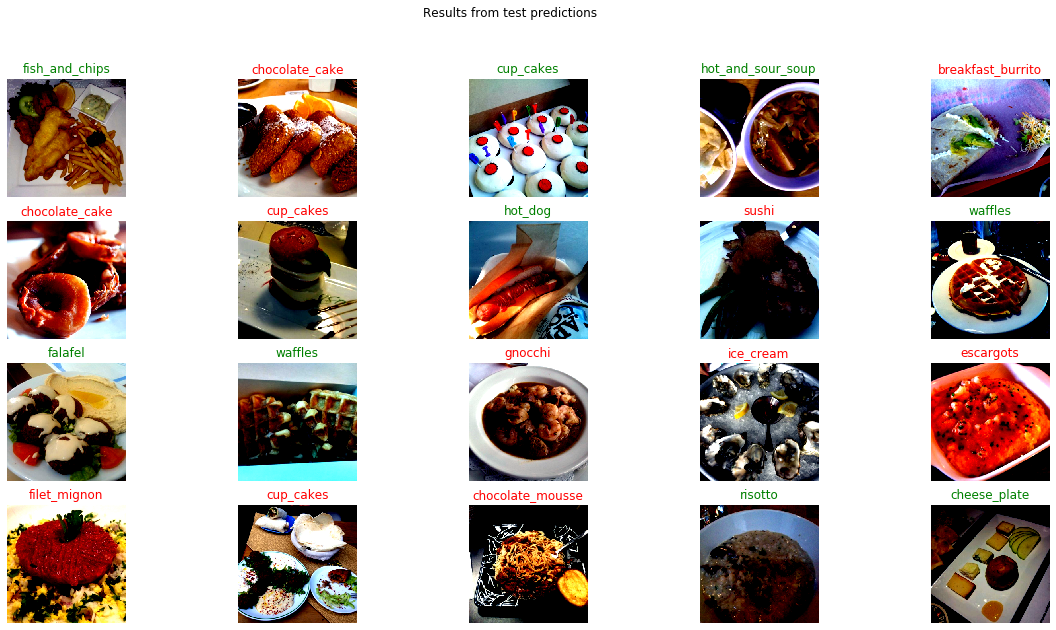

In [9]:
cols, rows = 5, 4
fig = plt.figure(figsize=(20,10))
fig.suptitle("Results from test predictions")

for i in range(1, cols*rows+1):
  fig.add_subplot(rows, cols, i)

  # randomly sellect image from dataset
  img = images[i-1]
  img = np.transpose(img, (1,2,0))
  img = img * (0.485, 0.456, 0.406) + (0.229, 0.224, 0.225)

  # display title as green if correct otherwise red
  color = "green" if predicted_classes[i-1] == real_classes[i-1] else "red"
  plt.title(predicted_classes[i-1], color=color)
  plt.axis("off")
  img = np.clip(img, 0, 1)
  plt.imshow(img, interpolation="nearest")
plt.show()

# Predict

**Load image from url**

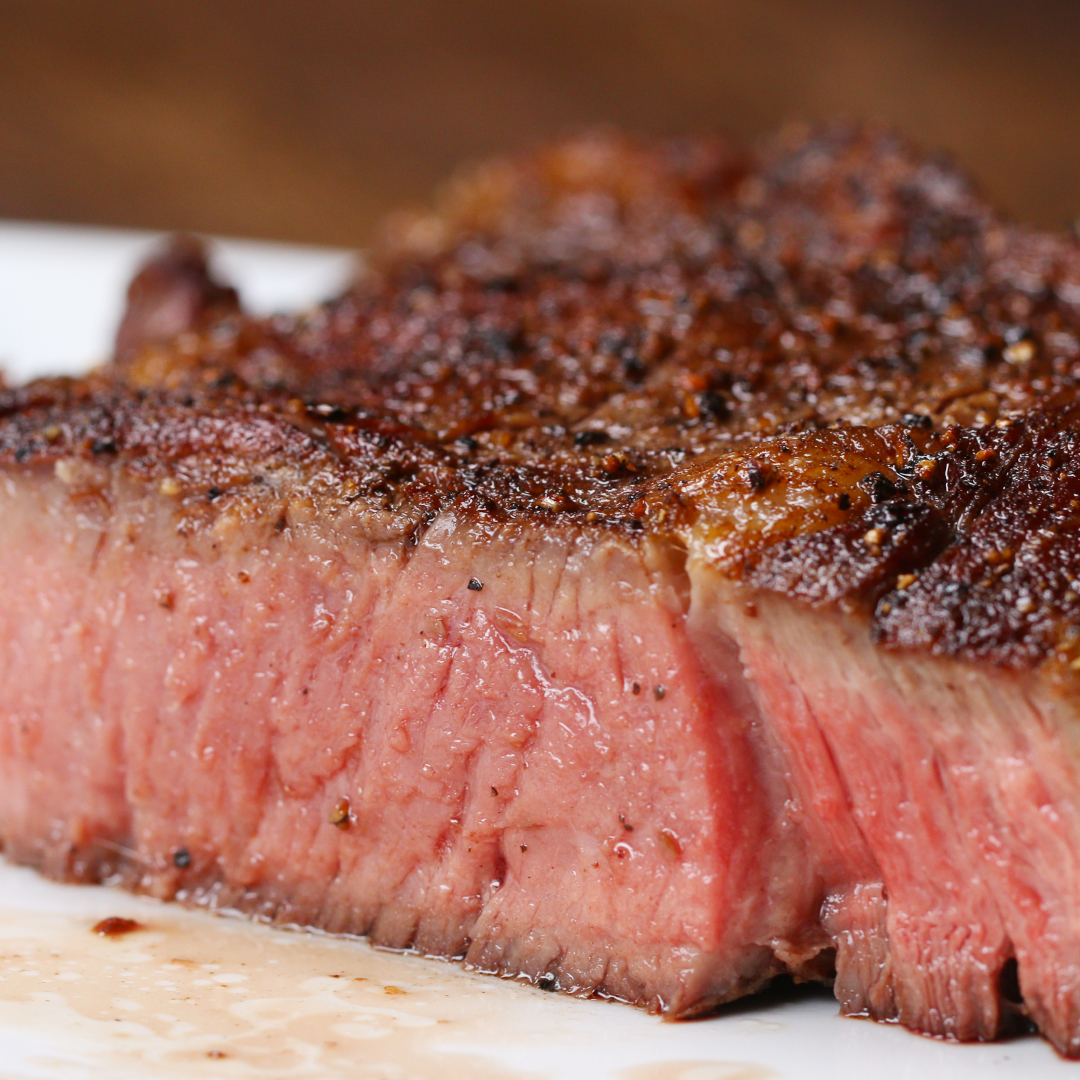

In [10]:
def loadImage(url):
    filename = url.split('/')[-1]
    img = utils.get_file(filename, url)
    img = Image.open(img)
    return img

img = loadImage("https://img.buzzfeed.com/video-api-prod/assets/1b97c3bbb24c45b892f582c8286c54bf/Thumb_A_FB.jpg")
img

**Format image for model input**

In [11]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

img = transform(img)
images = img.unsqueeze(0)

**Apply model on image**

In [12]:
img_class = predict(images)[0]
img_class

'steak'

# Nutritional lookup

**Search USDA for foods with predicted class**

In [13]:
client = UsdaClient(API_KEY)

# seach USDA with predicted image class as search term
food_results = client.search_foods(img_class, 1)

food = next(food_results)

# fetch food report for top result
food_report = client.get_food_report(food.id)
for nutrient in food_report.nutrients:
    print(nutrient.name, nutrient.value, nutrient.unit)

Energy 193.0 kcal
Protein 16.67 g
Total lipid (fat) 4.0 g
Carbohydrate, by difference 21.33 g
Fiber, total dietary 0.0 g
Sugars, total 0.67 g
Calcium, Ca 40.0 mg
Iron, Fe 3.0 mg
Sodium, Na 513.0 mg
Vitamin C, total ascorbic acid 0.0 mg
Vitamin A, IU 0.0 IU
Fatty acids, total saturated 1.0 g
Fatty acids, total trans 0.0 g
Cholesterol 33.0 mg
